# NIM/h for 1D Hyperelasticity Tutorial with Python JAX library

### This program solves 1D Hyperelasticity rod under tension.
### Coded with Jax library. By default, all variables are stored and computed in GPU machine
### Codes by Honghui Du, Qizhi He (du000211@umn.edu, qzhe@umn.edu)


Import libraries

In [9]:
import jax
import jax.numpy as np
from jax.flatten_util import ravel_pytree
from jax import random, vmap, jit

from jax.nn import relu


import itertools

import matplotlib.pyplot as plt

import os, sys

from functools import partial
import time
import jaxopt

from jax import config


from scipy.special import jacobi
from scipy.special import roots_jacobi


config.update('jax_enable_x64', True)


# Pre-processing

Shape function

In [10]:
def domain(gpos,x,dm):
    x=x.reshape(1,-1)
    nnodes=x.shape[1]
    dif = gpos * (np.ones((1,nnodes)))-x
    in_domain = np.all((dm - np.abs(dif)) >= 1e-8, axis=0)
    return in_domain


def cubwgt_vmap(dif,dm_v, max_v):
    """ Compute the cubic B-spline kernel function for shape function"""
    
    w,dwdx = np.zeros([1,max_v]), np.zeros([1,max_v])
    dwdxx= np.zeros([1,max_v])
    dwdxxx= np.zeros([1,max_v])

    ax = dm_v[0] 
    drdx = np.sign(dif[0])/ax 
    rx =  np.abs(dif[0])/ax 

    condition1 = rx > 1
    condition2 = rx <= 0.5
    condition3 = 0.5 < rx 

    w = np.where(condition2, (2/3) - 4*rx*rx + 4*rx **3 , w)
    dwdx = np.where(condition2, (-8*rx + 12*rx **2)*drdx, dwdx)
    dwdxx = np.where(condition2, (-8 + 24*rx)*drdx **2, dwdxx)
    dwdxxx = np.where(condition2, 24*drdx **3, dwdxxx)

    w = np.where(condition3, (4/3)-4*rx+4*rx*rx -(4/3)*rx**3, w)
    dwdx = np.where(condition3, (-4 + 8*rx - 4*rx **2)*drdx, dwdx)
    dwdxx = np.where(condition3, (8 - 8*rx)*drdx **2, dwdxx)
    dwdxxx = np.where(condition3, - 8*drdx **3, dwdxxx)

    w = np.where(condition1, 0, w)
    dwdx = np.where(condition1, 0, dwdx)
    dwdxx = np.where(condition1, 0, dwdxx)
    dwdxxx = np.where(condition1, 0, dwdxxx)

    return w,dwdx,dwdxx,dwdxxx


def shape2_singular_vmap(gpos, index_ind_each, size_ind_each, Xi, dm, max_v, EBC):
    """ Compute the Singular RK shape function"""

    x_v = Xi[index_ind_each,:]
    won = np.ones([1,max_v])
    zro=np.zeros([1,max_v])
    nv = x_v.reshape(1,max_v)
    dif = gpos*won-nv

    dm_v = dm[:,index_ind_each]

    w,dwdx,dwdxx, _= cubwgt_vmap(dif, dm_v, max_v)
    coe=0.5

    small_diff = np.abs(dif[0, :]) < 1e-10

    dist = np.where(small_diff, 1e-16, ((dif[0, :] / dm_v[0, :])**2)**coe)
    dist_dx = np.where(small_diff, 0, coe * ((dif[0, :] / dm_v[0, :])**2)**(coe - 1) * (2 * (dif[0, :] / dm_v[0, :]) / dm_v[0, :]))

    in_EBC = np.isin(index_ind_each, EBC)

    dwdx = dwdx.at[0, :].set(np.where(in_EBC, (dwdx[0, :] * dist - w[0, :] * dist_dx) / dist**2, dwdx[0, :]))
    w = w.at[0, :].set(np.where(in_EBC, w[0, :] / dist, w[0, :]))


    w = np.where(np.arange(max_v) >= size_ind_each, 0, w)
    dwdx = np.where(np.arange(max_v) >= size_ind_each, 0, dwdx)
    dwdxx = np.where(np.arange(max_v) >= size_ind_each, 0, dwdxx)

    p = np.vstack((won,dif,dif[[0],:]*dif[[0],:]))
    dpx = np.vstack((zro, won, 2*dif[0,:])) 
    dpxx = np.vstack((zro, zro, 2*won)) 



    B = p*np.vstack((w, w, w)) 
    Bdx = dpx*np.vstack((w, w, w)) 
    Bdxx = dpxx*np.vstack((w, w, w)) 


    aa = np.einsum('i,ji,ki->jk', w[0], p, p)
    daax = np.einsum('i,ji,ki->jk', dwdx[0], p, p) + \
        np.einsum('i,ji,ki->jk', w[0], p, dpx) + \
        np.einsum('i,ji,ki->jk', w[0], dpx, p)

    daaxx = np.einsum('i,ji,ki->jk', dwdxx[0], p, p) + \
            np.einsum('i,ji,ki->jk', w[0], p, dpxx) + \
            np.einsum('i,ji,ki->jk', w[0], dpx, dpx) + \
            2 * np.einsum('i,ji,ki->jk', dwdx[0], p, dpx) + \
            2 * np.einsum('i,ji,ki->jk', dwdx[0], dpx, p)



    pg = np.hstack((1, 0, 0))

    aa_inv = np.linalg.inv(aa)

    r = pg @ aa_inv
    drx = -r @ daax @ aa_inv
    drxx = -(r @ daaxx + 2 * drx @ daax) @ aa_inv

    dbx = p * dwdx
    dbxx = p * dwdxx
    dbxBdx = dpx * dwdx

    phi = r @ B
    dphix = drx @ B + r @ (dbx + Bdx)
    dphixx = drxx @ B + 2 * drx @ (dbx + Bdx) + r @ (dbxx + 2 * dbxBdx + Bdxx)


    return phi, dphix, dphixx



In [11]:

def gauss_lobatto_jacobi_weights(Q):
    """ 
    Compute Gauss lobatto quadrature points and weights between [-1,1]

    --- Inputs: the number of quadrature points ---
    --- Outputs: the quadrature points and weights ---

    """    
    X = roots_jacobi(Q-2, 1, 1)[0]
    X = np.concatenate((np.array([-1]), np.array(X), np.array([1])))
    W0 = jacobi(Q-1, 0, 0)(X)
    W = 2 / ((Q-1) * Q * W0**2)

    return X, W


def construct_subdomain_heaviside(Xi_rows, lb, ub, rx, part1, quad):

    X_quad, WX_quad = gauss_lobatto_jacobi_weights(quad)


    x_quad  = X_quad.reshape(-1,1)

    w_quad  = WX_quad.reshape(-1,1)


    subdomain = []
    subdomain_right = []
    subdomain_left = []

    List_right = []
    List_left = []
    List_right_NBC = []
    #############################################
    ii=-1

    for xi in Xi_rows:
        ii=ii+1

        left=max(xi[0]-rx,lb[0])
        right=min(xi[0]+rx,ub[0])


        lenx=(right-left)/part1

        x_quad_element, w_quad_element, jacobian_element=[], [], []
        for ll in range(part1):
            left_l=left+ll*lenx
            x_quad_element.append(left_l + lenx/2*(x_quad+1))

            jacobian_element.append(np.ones_like(x_quad)*(lenx/2))
            w_quad_element.append(w_quad)

        x_quad_element, w_quad_element, jacobian_element=np.vstack(x_quad_element), np.vstack(w_quad_element), np.vstack(jacobian_element)
        subdomain.append(np.hstack((x_quad_element,w_quad_element,jacobian_element)))
 
        for side in range(2):
            count=0
            if side==0:
                n=-1
                gsb=left
                count=count+1

                subdomain_left.append(gsb)
                List_left.append(ii)

            if side==1:

                n=1
                gsb=right
                count=count+1
                subdomain_right.append(gsb)
                List_right.append(ii)
                
                if abs(right-ub[0])<1e-5:
                    List_right_NBC.append(ii)

    subdomain, subdomain_left, subdomain_right  = np.vstack(subdomain), np.vstack(subdomain_left), np.vstack(subdomain_right)
    List_right, List_left, List_right_NBC  = np.array(List_right), np.array(List_left), np.array(List_right_NBC)
    return (subdomain, subdomain_left, subdomain_right,
                List_right, List_left, List_right_NBC)


MLP definition

In [12]:
    
def MLP(layers, activation=relu):
    def init(rng_key):
        def init_layer(key, d_in, d_out):

            lb_00, ub_00 = -(1 / np.sqrt(d_in)), (1 / np.sqrt(d_in))
            W = lb_00 + (ub_00-lb_00) * jax.random.uniform(key,shape=(d_in,d_out))
            b = random.uniform(key,shape=(d_out,))

            return W, b
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params
    def apply(params, inputs):
        for W, b in params[:-1]:
            outputs = np.dot(inputs, W) + b
            inputs = activation(outputs)
        W, b = params[-1]
        outputs = np.dot(inputs, W) + b
        return outputs
    return init, apply



Model definition

In [13]:
class NIM:
    def __init__(self, u_layers):    

        self.u_init, self.dis_apply = MLP(u_layers, activation=np.tanh)

        ux_params = self.u_init(rng_key = random.PRNGKey(1995))

        self.params = [[0.01*str for str in steee] for steee in ux_params]


        self.optimizer = jaxopt.ScipyMinimize(fun=self.loss,
                                            method  = 'L-BFGS-B', maxiter = 300000,
                                            callback = self.callback,
                                            jit = True,
                                            options = {'maxfun': 300000,
                                                    'maxcor': 100,
                                                    'maxls': 100,
                                                    'ftol' : 1.0e-20,
                                                    'gtol': 1.0e-20}) 
        
        _, self.unravel_params = ravel_pytree(self.params)

        self.itercount = itertools.count()
        self.loss_log = []
        self.loss_res_log = []
        self.loss_l2_log = []


    # Define load variational residuals
    def residual_net_C(self, params, u):

        dx = self.dis_apply(params, u).squeeze()
        dx = dx.at[EBC].set(0)

       
        Dis_external_x_left_all = np.zeros(Xi_rows.shape[0])
        Dis_external_x_right_all = np.zeros(Xi_rows.shape[0])
        Res_inner_x = (subdomain[:,0])*subdomain[:,1]*subdomain[:,2]
        Res_inner_x = Res_inner_x.reshape(Xi_rows.shape[0], part1 * quad)
        Res_inner_x_all = Res_inner_x.sum(axis=1)


        dux_x_left = (DPHIX_left_all * dx[Index_left_all]).sum(axis = 1)
        relu_dux_x_left = relu(dux_x_left+0.9) - 0.9
        Pxx_left = 3/2 * ((1 + relu_dux_x_left)**0.5 - 1)
        Dis_external_x = (Pxx_left * (-1))

        Dis_external_x_left_all = Dis_external_x_left_all.at[List_left].set(Dis_external_x)
        dux_x_right = (DPHIX_right_all * dx[Index_right_all]).sum(axis = 1)
        relu_dux_x_right = relu(dux_x_right+0.9) - 0.9
        Pxx_right = 3/2 * ((1 + relu_dux_x_right)**0.5 - 1)
        Dis_external_x = (Pxx_right * (1))
        Dis_external_x_right_all = Dis_external_x_right_all.at[List_right].set(Dis_external_x)
        Dis_external_x_right_all = Dis_external_x_right_all.at[List_right_NBC].set(0)


        Loss_x =  (Res_inner_x_all + Dis_external_x_right_all + Dis_external_x_left_all)


        return Loss_x
    



        return loss_1

    def l2_test(self, params, input):

        dx = self.dis_apply(params, input).squeeze()
        dx = dx.at[EBC].set(0)

        uxh = (PHI_test * dx[index_test]).sum(axis = 1)

        l2 = np.linalg.norm(uxh- ux_test) / np.linalg.norm(ux_test) 

        return l2
    

    def loss_res(self, params, input):

        res_1 = vmap(self.residual_net_C, (None, 0))(params, input)

        loss_1 = np.mean((res_1)**2)
        return loss_1  
    




    @partial(jit, static_argnums=(0,))
    def loss(self, params, input_batch):

        loss_resx = self.loss_res(params, input_batch)
        
        loss_func = loss_resx
        return loss_func 

    def callback(self, params):

        if self.index_opt % 1 == 0:
            elapsed_time = time.time() - self.start_time
            loss_value = self.loss(params, input_para)
            loss_res_value = self.loss_res(params, input_para)

            l2_value = self.l2_test(params, input_para)
            
            print('It: {0: d} | Loss: {1: .3e}| Loss_res: {2: .3e}|  L2: {3: .3e}| Time: {4: .2f}'.\
                format(self.index_opt, loss_value.item(), loss_res_value.item(), l2_value.item(), elapsed_time)) 

            self.loss_log.append(loss_value)
            self.loss_res_log.append(loss_res_value)
            self.loss_l2_log.append(l2_value)

        self.index_opt += 1


    def train(self):

        self.index_opt = 0
        self.start_time = time.time()
        self.solver_1_sol = self.optimizer.run(self.params, input_batch = input_para)

        loss_value = self.loss(self.solver_1_sol.params, input_para)
        loss_res_value = self.loss_res(self.solver_1_sol.params, input_para)
        l2_value = self.l2_test(self.solver_1_sol.params, input_para)
        
        print('Final: {0: d} | Loss: {1: .3e}| Loss_res: {2: .3e}| L2: {3: .3e}'.\
            format(self.index_opt, loss_value.item(), loss_res_value.item(), l2_value.item())) 

        self.loss_log.append(loss_value)
        self.loss_res_log.append(loss_res_value)
        self.loss_l2_log.append(l2_value)
    
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, input, PHI_in, index_in):

        dx = self.dis_apply(params, input).squeeze()
        dx = dx.at[EBC].set(0)

        uxh = (PHI_in * dx[index_in]).sum(axis = 1)
        return uxh

# Main program

Problem definition

In [14]:

lb = np.array([-1])
ub = np.array([1])

E = 1000
nu = 0.3
mu = E / (2 * (1 + nu))
lam = (E * nu) / ((1 + nu) * (1 - 2 * nu))

nx=41


nx_r=101

#######################################################################
Xi = np.linspace(lb[0], ub[0], nx).reshape(-1,1)
Xi_rows = np.linspace(lb[0], ub[0], nx_r).reshape(-1,1)
Xi_test = np.linspace(lb[0], ub[0], 301).reshape(-1,1)

exactU = lambda X: 1/135 * (68 + 105*X - 40*X**3 + 3*X**5)
exactStrain = lambda x: 1./9. * (x**4 - 8*x**2 + 7)
exactEnergy = lambda eps: (1+eps)**(3/2) - 3/2*eps - 1

ux_test = exactU(Xi_test).squeeze()



rx=(ub[0]-lb[0])/(nx-1)*2.5


nodes=Xi.shape[0]




basis = 'quadratic'
dmax=2.5
shape_fun=shape2_singular_vmap



path_f='Results_vnim_heaviside_singular' + '/' + str(nx) + '_' + str(nx_r) + '/'+ basis + '/'



if not os.path.exists(path_f):
    	os.makedirs(path_f)


dm = dmax*((ub[0]-lb[0])/(nx-1))*np.ones((1,nodes))

EBC = np.where(np.abs(Xi[:, 0] - lb[0]) < 1e-5)[0]

part1, quad = 4, 5



Shape function pre-computation and storage

In [15]:

############################Save################################


# (subdomain, subdomain_left, subdomain_right,
#                 List_right, List_left, List_right_NBC) = construct_subdomain_heaviside(Xi_rows, lb, ub, rx, part1, quad)


# in_domain = vmap(domain, (0, None, None))(subdomain[:,0].reshape(-1,1),Xi,dm)
# max_v = max(np.sum(in_domain, axis=1))

# def calculate_shape_function(point_group):
#     in_domain = vmap(domain, (0, None, None))(point_group,Xi,dm)
#     index_ind = -1 * np.ones((in_domain.shape[0], max_v)).astype(np.int64)
#     size_ind = np.zeros(in_domain.shape[0]).astype(np.int64)
#     for i in range(in_domain.shape[0]):
#         current_indices = np.where(in_domain[i, :])[0]
#         l = current_indices.size 
#         index_ind = index_ind.at[i, :l].set(current_indices)
#         size_ind = size_ind.at[i].set(l)

#     valid_mask = index_ind != -1

#     phi, dphix, dphixx = vmap(shape2_singular_vmap, (0, 0, 0, None, None, None, None)) (point_group, index_ind, size_ind, Xi, dm, max_v, EBC)
#     phi = np.where(valid_mask, phi, 0)
#     dphix = np.where(valid_mask, dphix, 0)
#     dphixx = np.where(valid_mask, dphixx, 0)

#     return phi, dphix, dphixx, index_ind

# PHI_all, DPHIX_all, DPHIXX_all, Index_all = calculate_shape_function(subdomain[:,0].reshape(-1,1))
# PHI_left_all, DPHIX_left_all, DPHIXX_left_all, Index_left_all = calculate_shape_function(subdomain_left[:,0].reshape(-1,1))
# PHI_right_all, DPHIX_right_all, DPHIXX_right_all, Index_right_all = calculate_shape_function(subdomain_right[:,0].reshape(-1,1))

# PHI_test, DPHIX_test, _, index_test = calculate_shape_function(Xi_test.reshape(-1,1))


# np.savez(path_f+'phi_list_saved_' +  str(nx) + '_' + str(nx_r) + '.npz', PHI_left_all=PHI_left_all, DPHIX_left_all=DPHIX_left_all, Index_left_all = Index_left_all, \
#          PHI_right_all=PHI_right_all, DPHIX_right_all=DPHIX_right_all, Index_right_all=Index_right_all, \
#          PHI_all = PHI_all, DPHIX_all = DPHIX_all, Index_all=Index_all, \
#          subdomain = subdomain, subdomain_right = subdomain_right, subdomain_left = subdomain_left,
#           List_right = List_right, List_left = List_left, List_right_NBC = List_right_NBC,  \
#           EBC=EBC,PHI_test = PHI_test, DPHIX_test = DPHIX_test, index_test=index_test)

###################################Load#####################################




loaded_data = np.load(path_f+'phi_list_saved_' +  str(nx) + '_' + str(nx_r) + '.npz')
PHI_left_all = np.array(loaded_data['PHI_left_all'])
DPHIX_left_all = np.array(loaded_data['DPHIX_left_all'])
Index_left_all = np.array(loaded_data['Index_left_all'])
PHI_right_all = np.array(loaded_data['PHI_right_all'])
DPHIX_right_all = np.array(loaded_data['DPHIX_right_all'])
Index_right_all = np.array(loaded_data['Index_right_all'])
PHI_all = np.array(loaded_data['PHI_all'])
DPHIX_all = np.array(loaded_data['DPHIX_all'])
Index_all = np.array(loaded_data['Index_all'])
subdomain = np.array(loaded_data['subdomain'])
subdomain_left = np.array(loaded_data['subdomain_left'])
subdomain_right = np.array(loaded_data['subdomain_right'])
List_right = np.array(loaded_data['List_right'])
List_left = np.array(loaded_data['List_left'])
List_right_NBC = np.array(loaded_data['List_right_NBC'])
EBC = np.array(loaded_data['EBC'])
PHI_test = np.array(loaded_data['PHI_test'])
DPHIX_test = np.array(loaded_data['DPHIX_test'])
index_test = np.array(loaded_data['index_test'])




Model training

It:  0 | Loss:  1.822e-02| Loss_res:  1.822e-02|  L2:  9.940e-01| Time:  0.38
It:  1 | Loss:  1.677e-02| Loss_res:  1.677e-02|  L2:  9.940e-01| Time:  0.53
It:  2 | Loss:  1.593e-02| Loss_res:  1.593e-02|  L2:  9.939e-01| Time:  0.55
It:  3 | Loss:  1.416e-02| Loss_res:  1.416e-02|  L2:  9.936e-01| Time:  0.57
It:  4 | Loss:  1.268e-02| Loss_res:  1.268e-02|  L2:  9.931e-01| Time:  0.60
It:  5 | Loss:  1.238e-02| Loss_res:  1.238e-02|  L2:  9.925e-01| Time:  0.62
It:  6 | Loss:  1.136e-02| Loss_res:  1.136e-02|  L2:  9.926e-01| Time:  0.65
It:  7 | Loss:  1.096e-02| Loss_res:  1.096e-02|  L2:  9.925e-01| Time:  0.68
It:  8 | Loss:  1.008e-02| Loss_res:  1.008e-02|  L2:  9.922e-01| Time:  0.72
It:  9 | Loss:  9.001e-03| Loss_res:  9.001e-03|  L2:  9.916e-01| Time:  0.76
It:  10 | Loss:  8.442e-03| Loss_res:  8.442e-03|  L2:  9.910e-01| Time:  0.79
It:  11 | Loss:  7.836e-03| Loss_res:  7.836e-03|  L2:  9.906e-01| Time:  0.81
It:  12 | Loss:  7.529e-03| Loss_res:  7.529e-03|  L2:  9.904e

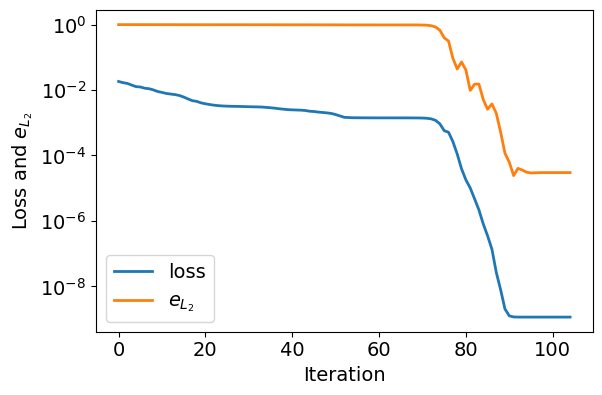

In [16]:



input_para = np.linspace(0.1, 0.2, 1)

u_layers = [1, 10, Xi.shape[0]]
model = NIM(u_layers)


model.train()
params = model.solver_1_sol.params

flat_params, _  = ravel_pytree(params)
np.save(path_f+'adv_params.npy', flat_params)
np.save(path_f+'adv_loss_all.npy', model.loss_log)
np.save(path_f+'adv_loss_res.npy', model.loss_res_log)
np.save(path_f+'adv_loss_l2.npy', model.loss_l2_log)
###################################################
flat_params = np.load(path_f+'adv_params.npy')
params = model.unravel_params(flat_params)

uh = model.predict_s(params, input_para, PHI_test, index_test)
duh = model.predict_s(params, input_para, DPHIX_test, index_test)

loss_all_log = np.load(path_f+'adv_loss_all.npy')
loss_res_log = np.load(path_f+'adv_loss_res.npy')
loss_l2_log = np.load(path_f+'adv_loss_l2.npy')

plt.figure(figsize = (6,4))
plt.plot(loss_all_log, lw=2, label='loss')
plt.plot(loss_l2_log, lw=2, label='$e_{L_2}$')

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Loss and $e_{L_2}$', fontsize=14)
plt.yscale('log')
plt.legend(loc='best',fontsize = 14)
plt.tight_layout()
plt.tick_params(labelsize=14)
plt.savefig(path_f+'loos_plot.jpg',dpi=200)